In [1]:
import psycopg2
import os
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [2]:
db_params = {
   'host': '127.0.0.1',
   "port" : '5432',
   'database': 'postgres',
   'user': 'postgres',
   'password': 'password'
}

In [3]:
# establishing the connection
conn = psycopg2.connect(
   database=db_params['database'],
   user=db_params['user'],
   password=db_params['password'],
   host=db_params['host'],
   port=db_params['port']
)
conn.autocommit = True

# creating a cursor object using the cursor() method
cursor = conn.cursor()

In [4]:
# deleting old data and creating a new database
sql = '''DROP database IF EXISTS stock_data;'''
cursor.execute(sql)
sql = '''CREATE database stock_data;'''
cursor.execute(sql)
# print("new database created")

In [5]:
# connecting to the newly database
db_params['database'] = 'stock_data'
engine = create_engine(f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}/{db_params["database"]}')

In [6]:
# defining the file paths for the data files
dirpath = os.path.join(os.getcwd(), 'data')
file_list = os.listdir(dirpath)

file_loc = {}

# mapping table names to filepaths
for file in file_list:
   filepath = os.path.join(dirpath, file)
   name = file[:-4].lower()
   name = ''.join(e for e in name if e.isalnum())
   file_loc[name] = filepath

# # printing some data from the tables to verify
# for filename, filepath in file_loc.items():
#    print(f"Contents of '{filename}' CSV file:")
#    df = pd.read_csv(filepath)
#    print(df.head(2))
#    print("\n")

In [7]:
# adding the data to the database
for filename, filepath in file_loc.items():
   df = pd.read_csv(filepath)
   df.columns = map(str.lower, df.columns)
   df.to_sql(filename, engine, if_exists='replace', index=False)

In [8]:
# SQL query to fetch trading data from the table
query = "SELECT date, close FROM hdb ORDER BY date;"

# Read data into a Pandas DataFrame
df = pd.read_sql(query, engine, index_col="date", parse_dates=True)

In [9]:
# Calculate the required moving averages
df["50_day_sma"] = df["close"].rolling(window=50, min_periods=1).mean()
df["500_day_sma"] = df["close"].rolling(window=500, min_periods=1).mean()
df["20_day_sma"] = df["close"].rolling(window=20, min_periods=1).mean()
df["200_day_sma"] = df["close"].rolling(window=200, min_periods=1).mean()
df["10_day_sma"] = df["close"].rolling(window=10, min_periods=1).mean()
df["5_day_sma"] = df["close"].rolling(window=5, min_periods=1).mean()

In [10]:
# Generate buy and sell signals based on crossovers
df["buy_signal"] = (df["50_day_sma"] > df["500_day_sma"]) & (df["50_day_sma"].shift(1) <= df["500_day_sma"].shift(1))
df["sell_signal"] = (df["20_day_sma"] < df["200_day_sma"]) & (df["20_day_sma"].shift(1) >= df["200_day_sma"].shift(1))

In [11]:
# Close buy positions
df["close_buy_positions"] = (df["10_day_sma"] > df["20_day_sma"]) & (df["10_day_sma"].shift(1) <= df["20_day_sma"].shift(1))

# Close sell positions
df["close_sell_positions"] = (df["5_day_sma"] > df["10_day_sma"]) & (df["5_day_sma"].shift(1) <= df["10_day_sma"].shift(1))

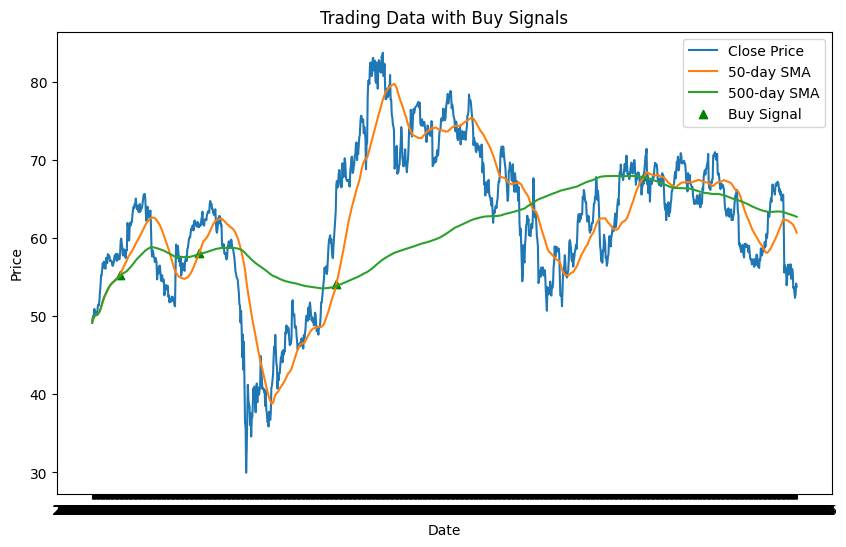

In [12]:
# Plot the data with signals
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close"], label="Close Price")
plt.plot(df.index, df["50_day_sma"], label="50-day SMA")
plt.plot(df.index, df["500_day_sma"], label="500-day SMA")

plt.scatter(df[df["buy_signal"]].index, df[df["buy_signal"]]["50_day_sma"], marker="^", color="g", label="Buy Signal")

plt.title("Trading Data with Buy Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

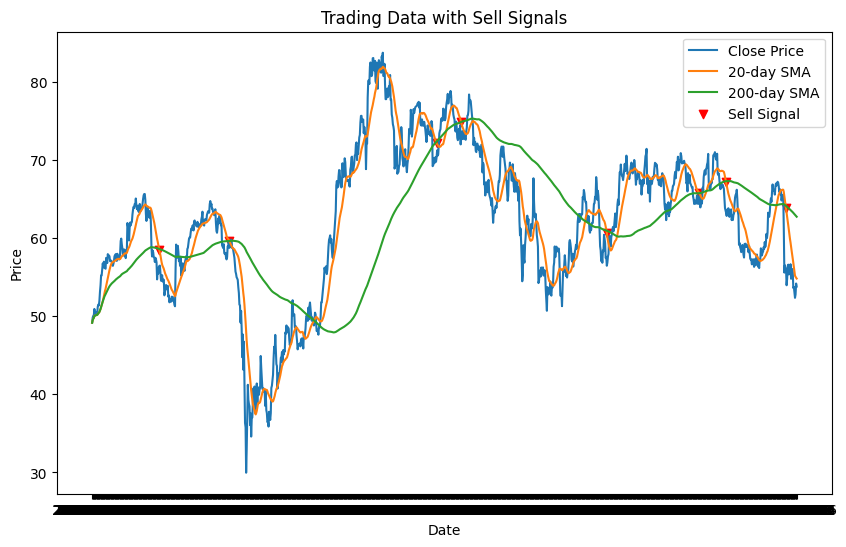

In [13]:
# Plot the data with signals
plt.figure(figsize=(10, 6))
plt.plot(df.index, df["close"], label="Close Price")
plt.plot(df.index, df["20_day_sma"], label="20-day SMA")
plt.plot(df.index, df["200_day_sma"], label="200-day SMA")

plt.scatter(df[df["sell_signal"]].index, df[df["sell_signal"]]["20_day_sma"], marker="v", color="r", label="Sell Signal")

plt.title("Trading Data with Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [19]:
# Assuming df contains your DataFrame with trading data and signals

# Calculate profits or losses for buy signals
df['buy_profit_loss'] = 0.0

# Initialize variables to track the position and entry price for buy signals
buy_position = 0
buy_entry_price = 0.0

# Iterate through the DataFrame to calculate profits or losses for buy signals
for index, row in df.iterrows():
    if row['buy_signal']:  # Buy signal
        buy_position = 1
        buy_entry_price = row['close']
    elif buy_position == 1 and row['close_buy_positions']:  # Close buy position
        sell_price = row['close']
        buy_profit_loss = sell_price - buy_entry_price
        df.at[index, 'buy_profit_loss'] = buy_profit_loss
        buy_position = 0

# Calculate profits or losses for sell signals
df['sell_profit_loss'] = 0.0

# Initialize variables to track the position and entry price for sell signals
sell_position = 0
sell_entry_price = 0.0

# Iterate through the DataFrame to calculate profits or losses for sell signals
for index, row in df.iterrows():
    if row['sell_signal']:  # Sell signal
        sell_position = 1
        sell_entry_price = row['close']
    elif sell_position == 1 and row['close_sell_positions']:  # Close sell position
        cover_price = row['close']
        sell_profit_loss = sell_entry_price - cover_price
        df.at[index, 'sell_profit_loss'] = sell_profit_loss
        sell_position = 0

# Filter DataFrame for rows with buy and sell signals
buy_sell_signals_df = df[df['buy_signal'] | df['sell_signal'] | df['close_buy_positions'] | df['close_sell_positions']]

# Display the DataFrame with buy and sell signals
print(buy_sell_signals_df[['close', 'buy_signal', 'close_buy_positions', 'buy_profit_loss', 'sell_signal', 'close_sell_positions', 'sell_profit_loss']])

                close  buy_signal  close_buy_positions  buy_profit_loss  \
date                                                                      
2019-02-26  50.410000       False                False              0.0   
2019-03-05  51.189999       False                 True              0.0   
2019-04-17  57.720001       False                False              0.0   
2019-04-25  57.419998       False                 True              0.0   
2019-05-01  58.099998        True                False              0.0   
...               ...         ...                  ...              ...   
2023-10-17  58.240002       False                 True              0.0   
2023-11-03  57.900002       False                False              0.0   
2023-11-14  58.700001       False                 True              0.0   
2024-01-22  56.099998       False                False              0.0   
2024-01-30  55.720001       False                False              0.0   

            sell_signal 

In [15]:
# Close the database connection
conn.close()